# Radar signal processing

## Step 1 - Radar parameter setting

### Modules & Packages

In [55]:
import numpy as np
import numpy.linalg as LA               # for norm
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d
from scipy import interpolate
from math import floor, ceil
from copy import deepcopy
from cmath import phase

# MUSIC
import scipy.signal as ss
import operator

### Radar paramter variables

In [56]:
## constant
c = 3e8     # speed of light [m/s]


## waveform parameters
wave_param = {
    'f_c' : 77e9,                   # center frequency [Hz]
    'range_max' : 50,               # maximum detectable range [m]
    'range_res' : 0.08338,          # range resolution [m]
    'velocity_max' : 6.0877,            # maximum detectable velocity [m/2]
    'sweep_fact' : 6,               # sweep time factor (5~6)
    'range_fft_size' : 256,         # range fft size
    'doppler_fft_size' : 128,       # doppler fft size
    'chirp_guard_time' : 100*1e-6   # time between consecutive chirps [s]
}

## antenna radiation pattern
default_rad_pattern = {
    'type' : 'patch',       # 'isotropic' or 'patch'
    'antenna_gain' : 9,     # antenna gain [dB]
    'v_3dB_width' : 65,     # vertical 3dB beamwidth [deg]
    'v_SLA' : 30,           # vertical sidelobe attenuation [dB]
    'h_3dB_width' : 65,     # horizontal 3dB beamwidth [deg]
    'h_SLA' : 30            # horizontal sidelobe attenuation [dB]
}

## antenna parameters (Rx)
ant_params_rx = {
    'type' : 'planner',                 # 'planar' or 'custom'
    'pattern' : default_rad_pattern,    
    'v_n_elements' : 1,                 # the number of vertical elements
    'h_n_elements' : 4,                # the number of horizontal elements
    'v_spacing' : 0.5,                  # vertical antenna spacing [lambda]
    'h_spacing' : 0.5                   # horizontal antenna spacing [lambda]
    
}

## antenna parameters (Tx) - assume that Tx has the same radiation pattern as Rx, but only one antenna --> not MIMO
ant_params_tx = deepcopy(ant_params_rx) # deepcopy!
ant_params_tx['v_n_elements'] = 1
ant_params_tx['h_n_elements'] = 1


ego = {
    'location' : np.array([[0, 0, 0]]),
    'velocity' : np.array([[0, 0, 0]]),
    'radar_orientation' : np.array([0, 0, 0.7071, 0.7071])}        # orientation (quaternion) of radar module

### Computation additional wavefrom parameters

In [57]:
wave_param['lambda'] = c / wave_param['f_c']                                # wavelength [m]
wave_param['rtt_max'] = 2 * wave_param['range_max'] / c                     # maximum round trip time [s]

wave_param['sweep_time'] = wave_param['lambda'] / (4 * wave_param['velocity_max']) - wave_param['chirp_guard_time'] # sweep time [s]
wave_param['bw'] = c / wave_param['range_res'] / 2                          # bandwidth [Hz]
wave_param['sweep_slope'] = wave_param['bw'] / wave_param['sweep_time']     # sweep slope [Hz/s] 

# detemine sampling rate
fr_max = wave_param['sweep_slope'] * wave_param['rtt_max']          # maximum beat frequency due to range
fd_max = 2 * wave_param['velocity_max'] / wave_param['lambda']             # maximum beat frequency due to doppler shift
wave_param['fb_max'] = fr_max + fd_max                              # maximum beat frequency [Hz]

wave_param['fs'] = 10000e3   # sampling rate [# sample/s]
# wave_param['fs'] = max(2*wave_param['fb_max'], wave_param['bw'])    # sampling rate [# sample/s]

wave_param['ts'] = 1/wave_param['fs']                               # sampling time [s]

# maximum # of samples taken in a chirp
wave_param['max_samples_per_chirp'] = floor((wave_param['sweep_time'] - wave_param['rtt_max']) / wave_param['ts'])

### Objects state (location, velocity, SNR)

In [58]:
pt1 = {
    'location' : np.array([[20, 10, 0]]),
    'velocity' : np.array([[0, -3, 0]]),
    'SNR_dB' : 30
}
pt2 = {
    'location' : np.array([[10, 5, 0]]),
    'velocity' : np.array([[0, -4, 0]]),
    'SNR_dB' : 30
}
pt3 = {
    'location' : np.array([[-5, 20, 0]]),
    'velocity' : np.array([[0, 4, 0]]),
    'SNR_dB' : 30
}

pt4 = {
    'location' : np.array([[-15, 15, 0]]),
    'velocity' : np.array([[0, 4, 0]]),
    'SNR_dB' : 30
}

pt5 = {
    'location' : np.array([[0, 30, 0]]),
    'velocity' : np.array([[0, 4, 0]]),
    'SNR_dB' : 30
}

# pt = [pt1, pt2, pt3, pt4, pt5]
pt = [pt1, pt2]

### Summary of wavefrom parameters

In [59]:
print('---- Waveform parameters ----')
print('Carrier frequency: %.2f [GHz]' %(wave_param['f_c'] / 1e9))
print('Maximum target range: %.2f [m]' %(wave_param['range_max']))
print('Range resolution: %.2f [m]' %(wave_param['range_res']))
print('Maximum target speed: %.2f [km/h]' %(wave_param['velocity_max'] * 3.6))
print('Sweep time: %.2f [us]' %(wave_param['sweep_time'] * 1e6))
print('Sweep bandwidth: %.2f [MHz]' %(wave_param['bw'] / 1e6))
print('Maximum beat frequency: %.2f [Mhz]' %(wave_param['fb_max'] / 1e6))
print('Sampling rate: %.2f [Mhz]' %(wave_param['fs'] / 1e6))
print('Sampling interval: %f [us]' %(wave_param['ts'] * 1e6))
print('Maximum samples per chirp: %d' %(wave_param['max_samples_per_chirp']))
print('Range FFT size: %d' %(wave_param['range_fft_size']))
if wave_param['max_samples_per_chirp'] < wave_param['range_fft_size'] :
    print(2, '[WARNING] range FFT size is greater than maximum available samples')
        
print('Doppler FFT size: %d' %(wave_param['doppler_fft_size']))
print('Total time for %d chirps: %f [us]' %(wave_param['doppler_fft_size'], 
      wave_param['doppler_fft_size']*(wave_param['sweep_time'] + wave_param['chirp_guard_time']) * 1e6))
print('----------------------------')

---- Waveform parameters ----
Carrier frequency: 77.00 [GHz]
Maximum target range: 50.00 [m]
Range resolution: 0.08 [m]
Maximum target speed: 21.92 [km/h]
Sweep time: 60.00 [us]
Sweep bandwidth: 1798.99 [MHz]
Maximum beat frequency: 10.00 [Mhz]
Sampling rate: 10.00 [Mhz]
Sampling interval: 0.100000 [us]
Maximum samples per chirp: 596
Range FFT size: 256
Doppler FFT size: 128
Total time for 128 chirps: 20479.873298 [us]
----------------------------


## Step 2 - Radar signal modeling

### 2-1 Functions

In [60]:
def getRotationMatrixFromVector(q):
    """ 
    compute 3x3 rotation matrix from quaternion 
    orientation of GCS relative to LCS (Android system)
    q = [cos(theta/2), ex sin(theta/2), ey sin(theta/2), ez sin(theta/2)]"""
    
    if q.size != 4:
        print('Dimension error')
        
    q = q / np.sqrt(sum(q**2))

    
    ## Rotation matrix from quaternion
    sq_q1 = 2 * q[1]**2
    sq_q2 = 2 * q[2]**2
    sq_q3 = 2 * q[3]**2
    q1_q2 = 2 * q[1] * q[2]
    q3_q0 = 2 * q[3] * q[0]
    q1_q3 = 2 * q[1] * q[3]
    q2_q0 = 2 * q[2] * q[0]
    q2_q3 = 2 * q[2] * q[3]
    q1_q0 = 2 * q[1] * q[0]

    rotMat = np.array([[1 - sq_q2 - sq_q3, q1_q2 - q3_q0, q1_q3 + q2_q0],
            [q1_q2 + q3_q0, 1 - sq_q1 - sq_q3, q2_q3 - q1_q0],
            [q1_q3 - q2_q0, q2_q3 + q1_q0, 1-sq_q1 - sq_q2]])
    
    return rotMat

def getSteeringVector(antenna_params, ray_vectors_ref_frame, quat):
    
    ## Antenna parameters
    v_n = antenna_params['v_n_elements']
    h_n = antenna_params['h_n_elements']
    v_spacing = antenna_params['v_spacing']
    h_spacing = antenna_params['h_spacing']
    
    radiation_pattern = antenna_params['pattern']
    
    antenna_gain = radiation_pattern['antenna_gain']
    v_SLA = radiation_pattern['v_SLA']
    h_SLA = radiation_pattern['h_SLA']
    v_3dB_width = radiation_pattern['v_3dB_width']
    h_3dB_width = radiation_pattern['h_3dB_width']
    
    ## Transform ray vectors to local coordinate frame
    
    # consider downtilt angle (rotate along y axis)
    rotMat = getRotationMatrixFromVector(quat)

    ray_vectors_local_frame = rotMat.transpose() @ ray_vectors_ref_frame.transpose()
    ray_vectors_local_frame = ray_vectors_local_frame.transpose()

    x_ref = ray_vectors_local_frame[:,0]
    y_ref = ray_vectors_local_frame[:,1]
    z_ref = ray_vectors_local_frame[:,2]
    
    ## Antenna gain
    AOD = np.arctan2(z_ref, x_ref)
    ZOD = np.arctan2(z_ref, y_ref)
    
    A_v = -12 * ((AOD * 180/np.pi - 90) / h_3dB_width)**2
    A_v[A_v < - v_SLA] = -v_SLA

    A_h = -12 * ((ZOD * 180/np.pi - 90) / v_3dB_width)**2
    A_h[A_h < - h_SLA] = -h_SLA

    A_total = A_v + A_h
    A_total[A_total < -h_SLA] = -h_SLA
    A_total = A_total + antenna_gain

    ## Steering vector
    antenna_loc = np.arange(0, h_spacing*h_n, h_spacing).reshape(h_n, 1) + 1j*np.arange(0, v_spacing*v_n, v_spacing)
    
    if antenna_loc.size != 0:
        antenna_loc = antenna_loc[:] - antenna_loc[0]
    else:
        antenna_loc = [0, ]
    
    antenna_loc_real_imag = np.concatenate((np.real(antenna_loc).reshape(len(antenna_loc),1), np.imag(antenna_loc)), axis = 1)
    antenna_loc = np.concatenate((antenna_loc_real_imag, np.zeros((len(antenna_loc), 1))), axis = 1)

    n_antenna_elements = antenna_loc.shape[0]  # check this part
    n_rays = ray_vectors_local_frame.shape[0]  # check this part
    
    for k in range(n_rays):
        phase_diff = 2 * np.pi * (antenna_loc @ np.transpose(ray_vectors_local_frame[k]).reshape(antenna_loc.shape[1],1))
        if 'steering_vec' not in locals():
            steering_vec = np.exp(-1j*phase_diff)
        else:
            steering_vec = np.concatenate((steering_vec, np.exp(-1j*phase_diff)), axis = 1)
    
    return A_total, steering_vec

### 2-2 modeling variables

In [61]:
## Extract essential parameters
c = 3e8

f_c = wave_param['f_c']         # center freq
rtt_max = wave_param['rtt_max']
sweep_time = wave_param['sweep_time']
sweep_slope = wave_param['sweep_slope']
fs = wave_param['fs']
ts = wave_param['ts']           # sampling time
fb_max = wave_param['fb_max']
range_fft_size = wave_param['range_fft_size']
doppler_fft_size = wave_param['doppler_fft_size']
chirp_guard_time = wave_param['chirp_guard_time']
wave_lambda = wave_param['lambda']

ego_radar_orientation = ego['radar_orientation']
h_n_element = ant_params_rx['h_n_elements']
v_n_element = ant_params_rx['v_n_elements']
range_max = wave_param['range_max']
velocity_max = wave_param['velocity_max']

### 2-3 Computation additional modeling paramters

In [62]:
## compute relativec position and velocity
n_pt = len(pt)

pt_ranges, pt_velos, pt_angles = [], [], []
pt_unit_dir_vecs = np.zeros((n_pt, 3))

for k in range(n_pt):
    rel_pos = pt[k]['location'] - ego['location']
    
    # calculation
    curr_unit_dir_vec = rel_pos / LA.norm(rel_pos)
    curr_radial_velo = curr_unit_dir_vec @ pt[k]['velocity'].transpose() - curr_unit_dir_vec @ ego['velocity'].transpose()
    curr_radial_angle = np.arctan(pt[k]['location'][0, 0] / pt[k]['location'][0, 1])

    # append
    pt_ranges.append(LA.norm(rel_pos))
    pt_velos.append(float(curr_radial_velo))
    pt_angles.append(float(curr_radial_angle))

    pt_unit_dir_vecs[k, :] = curr_unit_dir_vec


## compute sampling index/time --> This means that 
sample_start_idx = ceil(rtt_max / ts)
sample_idx = np.arange(sample_start_idx, floor(sweep_time / ts))
if len(sample_idx) >= range_fft_size :
    sample_idx = sample_idx[:range_fft_size]
else:
    print('[WARNING] Insufficient sample size. Range FFT size will be reduced from %d to %d' %(range_fft_size, len(sample_idx)))
    range_fft_size = len(sample_idx)
sample_time = sample_idx * ts

## compute # rx antennas
if ant_params_rx['type'] == 'planner':
    n_antenna = ant_params_rx['h_n_elements'] * ant_params_rx['v_n_elements']
else:
    print(ant_params_rx['type'] + ' is not supported yet')
    
## compute frequency to range & frequencty to velocity
# range
frequency_interval = fs * np.arange(0, range_fft_size)/range_fft_size
pt_range = (frequency_interval*c/(2*sweep_slope)).reshape(range_fft_size, 1)

# velocity
inter_chirp_time = sweep_time + chirp_guard_time

wave_interval = 2 * np.pi / doppler_fft_size * np.arange(0, doppler_fft_size - 1) - np.pi   # wave_interval * (N/2) = pi,
wave_interval = np.concatenate((wave_interval, [np.pi]))
pt_velocity  = wave_lambda * wave_interval / (4 * np.pi * inter_chirp_time)

# angle
angle_size = 181

wave_interval = 2 * np.pi / angle_size * np.arange(0, angle_size - 1) - np.pi   # wave_interval * (N/2) = pi,
wave_interval = np.concatenate((wave_interval, [np.pi]))
pt_angle  = np.arcsin(wave_lambda * wave_interval / (2 * np.pi * wave_lambda / 2)) * 180 / np.pi

angles_range = np.linspace(-np.pi/2,np.pi/2, angle_size).reshape(angle_size, 1)   # 실제 angle!! pt_angle하고는 다르다.

### 2-4 Tx signal modeling

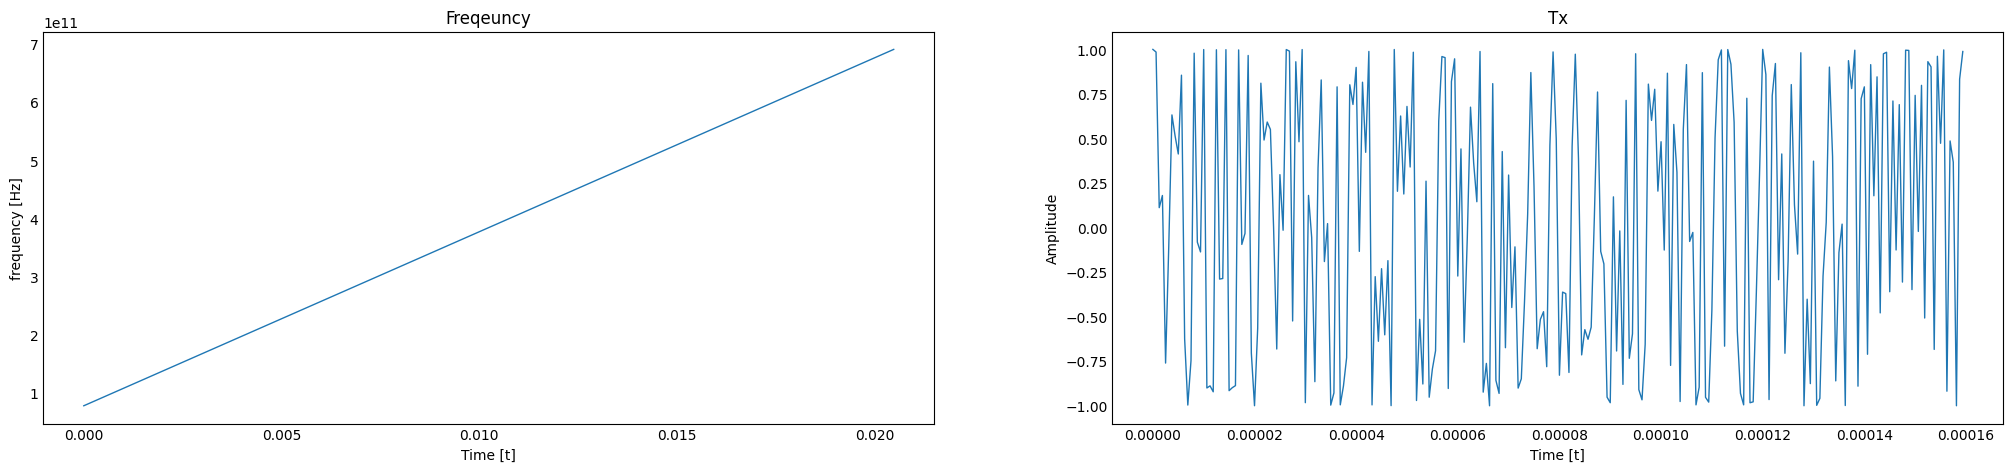

In [63]:
## calculation
chirp_time = sweep_time + chirp_guard_time
t = np.linspace(0, doppler_fft_size*chirp_time, range_fft_size*doppler_fft_size)   
 
angle_freq = f_c*t + (sweep_slope*t**2)/2       # Tx signal angle speed
freq = f_c + sweep_slope*t                      # Tx frequency
Tx = np.cos(2*np.pi*angle_freq)                 # Waveform of Tx

## plot
fig_size = (20, 4)
plt.rcParams["figure.figsize"] = fig_size
plt.subplot(121)
plt.title('Freqeuncy')
plt.xlabel('Time [t]')
plt.ylabel('frequency [Hz]')
plt.plot(t, freq, linewidth = '1')

plt.subplot(122)
plt.title('Tx')
plt.xlabel('Time [t]')
plt.ylabel('Amplitude')
plt.plot(t[:range_fft_size], Tx[:range_fft_size], linewidth = '1')
plt.show() 

### 2-5 Rx signal modeling

c:\Users\YoungJin\anaconda3\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[22.360679774997898, 11.180339887498949]


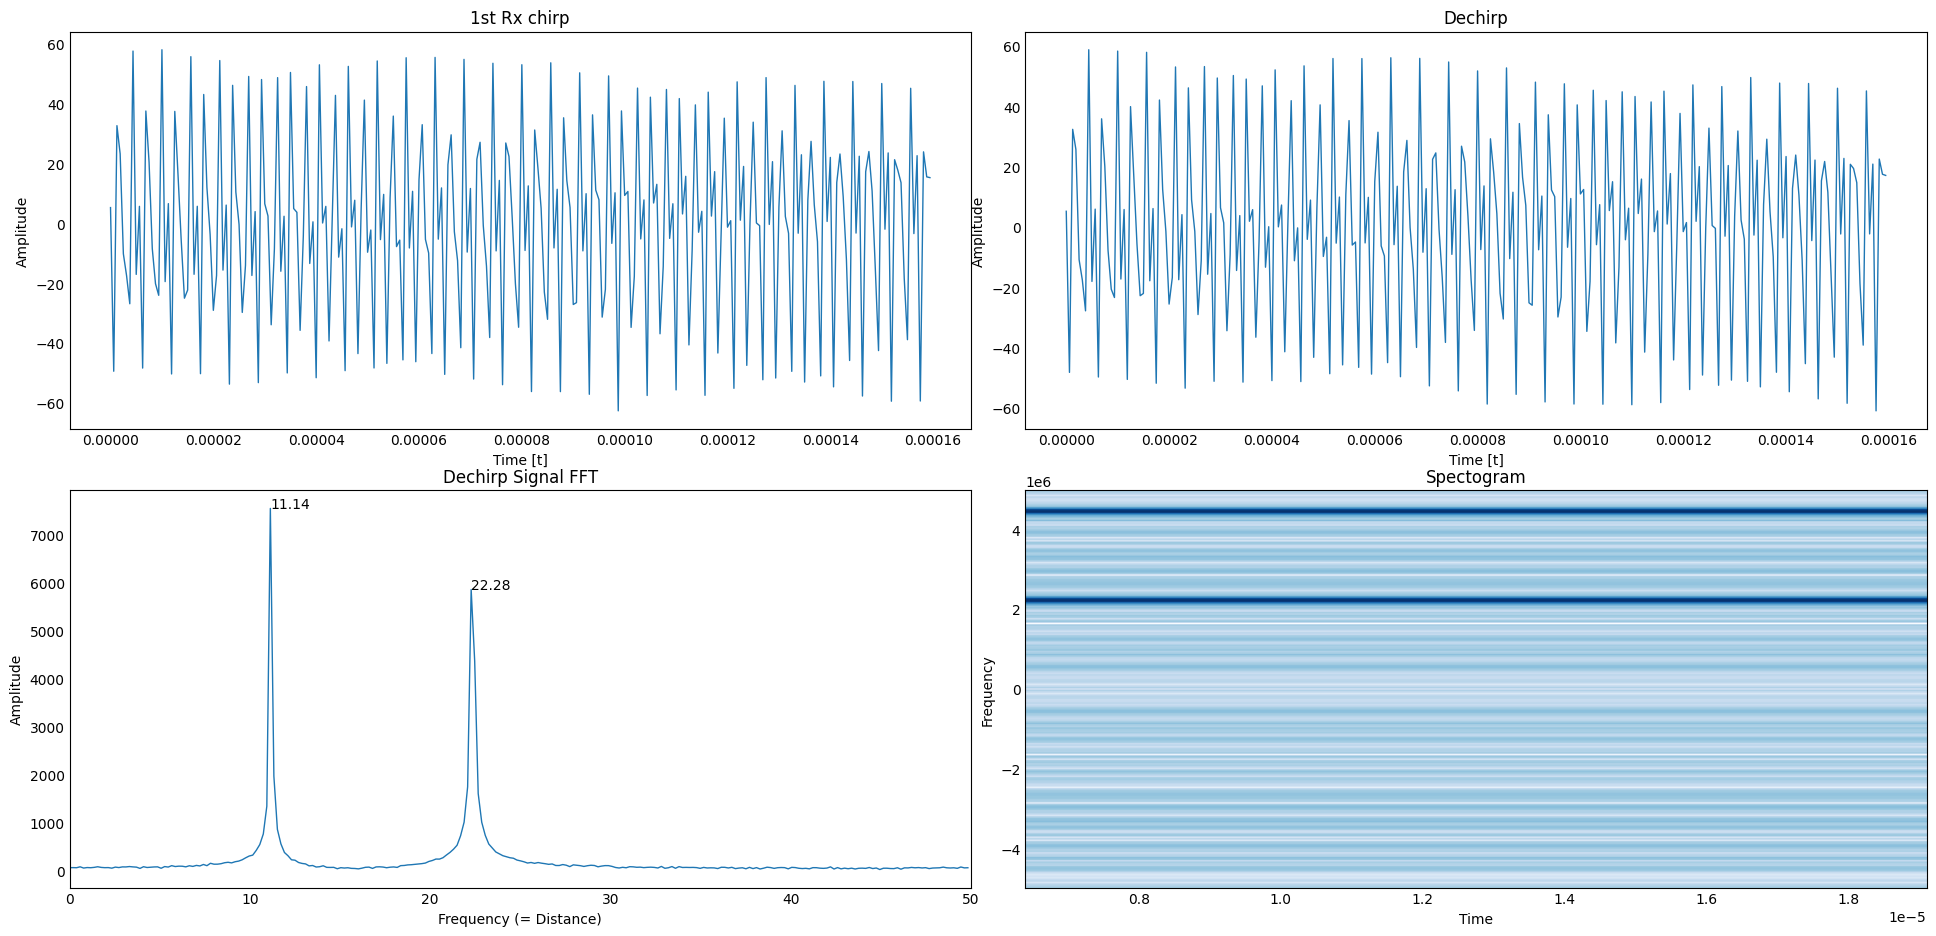

In [64]:
## initialize
fft_1D = np.zeros((range_fft_size, doppler_fft_size, n_antenna), dtype = 'complex_')
Rx_sig = np.random.randn(n_antenna, doppler_fft_size, range_fft_size).astype('complex_')

## preparation
inter_chirp_time = sweep_time + chirp_guard_time    # calculate inter_chirp_time

# steering vector
gain_tx, s_vec_tx = getSteeringVector(ant_params_tx, pt_unit_dir_vecs, ego['radar_orientation'])
gain_rx, s_vec_rx = getSteeringVector(ant_params_rx, pt_unit_dir_vecs, ego['radar_orientation'])

## calculate Rx signal   
for chirp_idx in range(doppler_fft_size):
    dechirp_sig = np.random.randn(range_fft_size, n_antenna).astype('complex_')   # initialize Dechirp
    
    for pt_idx in range(n_pt):
        # basic component
        curr_range = pt_ranges[pt_idx] + pt_velos[pt_idx] * inter_chirp_time * chirp_idx
        curr_td = 2 * curr_range / c
        curr_delay = sample_time - curr_td
        curr_SNR_dB = pt[pt_idx]['SNR_dB']
        curr_SNR_linear = 10**(curr_SNR_dB/20)
        
        for ant_idx in range(n_antenna):
            curr_ant_phase = phase(s_vec_rx[ant_idx, pt_idx])   # antenna!! 
            
            # summing Rx signal
            Rx_sig[ant_idx, chirp_idx, :] += curr_SNR_linear  * s_vec_rx[ant_idx, pt_idx] * np.exp(1j*(2*np.pi*(sweep_slope*curr_td*sample_time+f_c*curr_td)-np.pi*sweep_slope*curr_td**2))
            dechirp_sig[:,ant_idx] += curr_SNR_linear * np.exp(1j * 2*np.pi*(f_c*curr_td + sweep_slope*curr_td*sample_time 
                                                                              - 0.5*sweep_slope*curr_td**2) + curr_ant_phase)   ## dechirp means signal which has beat frequency
    ## 1D FFT
    for ant_idx in range(n_antenna):
        curr_range_fft = np.fft.fft(dechirp_sig[:, ant_idx])
        fft_1D[:range_fft_size, chirp_idx, ant_idx] = curr_range_fft[:range_fft_size]        

## plot    
fig_size = (20, 10)
THRESHLOD = 5000

plt.rcParams["figure.figsize"] = fig_size

plt.subplot(221)
plt.title('1st Rx chirp')
plt.xlabel('Time [t]')
plt.ylabel('Amplitude')
plt.plot(t[:range_fft_size], Rx_sig[0, doppler_fft_size - 1, :], linewidth = '1')

plt.subplot(222)
plt.title('Dechirp')
plt.xlabel('Time [t]')
plt.ylabel('Amplitude')
plt.plot(t[:range_fft_size], dechirp_sig[:, 0], linewidth = '1')


plt.subplot(223)
fft_1D_plot = abs(deepcopy(fft_1D[:, 0, 0]))
pt_range_arr = list(deepcopy(pt_range).reshape(-1))
plt.xlabel('Frequency (= Distance)')
plt.ylabel('Amplitude')
plt.title('Dechirp Signal FFT')
plt.plot(pt_range_arr, fft_1D_plot, linewidth = '1')
plt.xlim([0, range_max])
for i in range(range_fft_size):
    if fft_1D_plot[i] > THRESHLOD:
        plt.text(pt_range_arr[i], fft_1D_plot[i], '{:.2f}'.format(pt_range_arr[i]))
print(pt_ranges)

plt.subplot(224)
plt.specgram(dechirp_sig[:, 0], range_fft_size-1, fs)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectogram')
plt.tight_layout(pad=3, w_pad=0.05, h_pad=0.05)
plt.show()

## Step 3 - Radar signal processing

### 3-1 Range-Doppler map

[-1.3416407864998738, -1.7888543819998317]
(256, 128, 4)


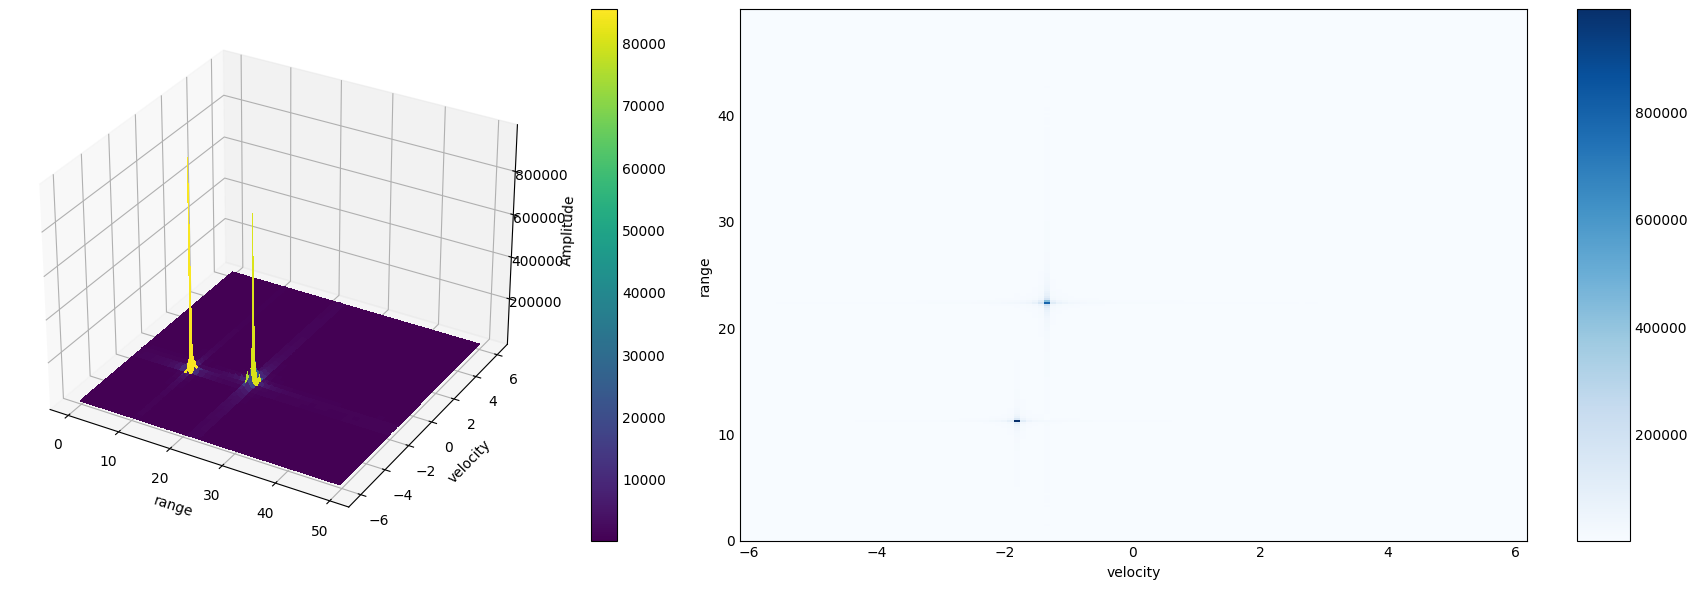

In [65]:
## initialize
fft_2D = np.zeros(fft_1D.shape, dtype = 'complex_')  # complex를 살려줘야 한다. 실수로만 하니 당연히 대칭!!
print(pt_velos)
print(fft_2D.shape)


## 2D FFT
for ant_idx in range(n_antenna):
    fft_2D[:, :, ant_idx] = np.fft.fft(fft_1D[:, :, ant_idx].copy(), axis = 1)
    fft_2D[:, :, ant_idx] = np.fft.fftshift(fft_2D[:, :, ant_idx], axes = 1)

Range_Doppler_fft = abs(fft_2D[:, :, 0])

## plot
fig_size, scale = (20, 6), 1/2
fig = plt.figure(figsize = fig_size)

# 1st image
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(pt_range, pt_velocity, Range_Doppler_fft, cmap='viridis', antialiased=False)
fig.colorbar(surf, ax=ax1)
ax1.set_xlabel('range')
ax1.set_ylabel('velocity')
ax1.set_zlabel('Amplitude')

# 2nd image
# plt.style.use('_mpl-gallery-nogrid')
ax2 = fig.add_subplot(122)
pmesh = ax2.pcolormesh(pt_velocity, pt_range, Range_Doppler_fft, vmax = Range_Doppler_fft.max())
ax2.set_xlabel('velocity')
ax2.set_ylabel('range')

fig.colorbar(pmesh, ax=ax2, aspect=10)
fig.tight_layout()

plt.show()

In [66]:
print(Range_Doppler_fft.shape)
print(pt_velocity.shape, pt_range.shape)

(256, 128)
(128,) (256, 1)


### 3-2 CFAR

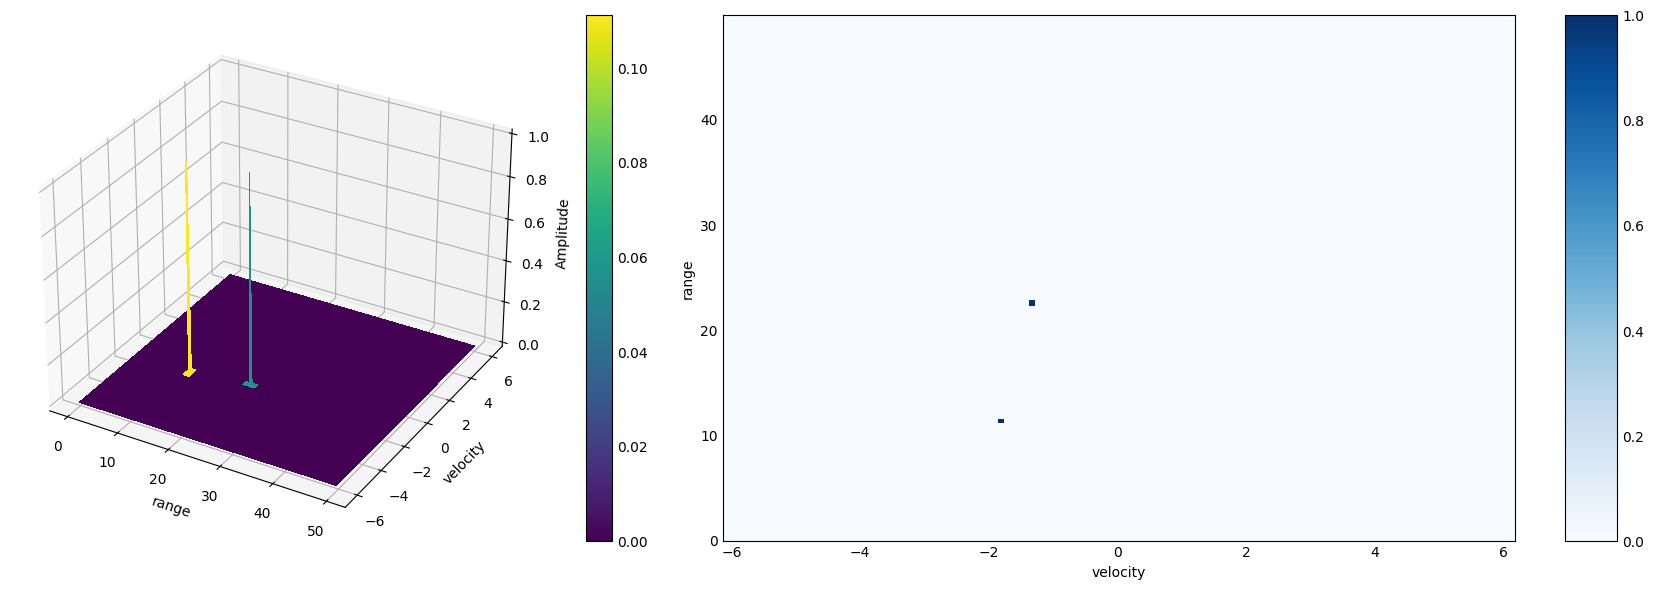

In [67]:
Tr, Td, Gr, Gd, offset = 2, 1, 2, 1, 3.3

dB_Doppler_fft = 10*np.log10(abs(fft_2D[:, :, 0]))
dB_Doppler_fft = dB_Doppler_fft/(dB_Doppler_fft.max())
 
for i in range(Tr+Gr, range_fft_size - (Gr+Tr)):
    for j in range(Td+Gd, doppler_fft_size - (Gd+Td)):
        noise_level = 0
        for p in range(i-(Tr+Gr),  i+(Tr+Gr)+1):
            for q in range(j-(Td+Gd), j+(Td+Gd)+1):
                if (abs(i-p)> Gr or abs(j-q)>Gd):
                    noise_level += 10**(dB_Doppler_fft[p,q]/10)

        threshold = 10*np.log10(noise_level/(2*(Td+Gd+1)*2*(Tr+Gr+1)-(Gr*Gd)-1))
        threshold = threshold + offset

        CUT = dB_Doppler_fft[i,j]
        
        if (CUT < threshold):
            dB_Doppler_fft[i,j] = 0
        else:
            dB_Doppler_fft[i,j] = 1

dB_Doppler_fft[(dB_Doppler_fft != 1) & (dB_Doppler_fft != 0)] = 0

## plot
fig_size, scale = (20, 6), 1/2
fig = plt.figure(figsize = fig_size)

# 1st image
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(pt_range, pt_velocity, dB_Doppler_fft, cmap='viridis', antialiased=False)
fig.colorbar(surf, ax=ax1)
ax1.set_xlabel('range')
ax1.set_ylabel('velocity')
ax1.set_zlabel('Amplitude')

# 2nd image
# plt.style.use('_mpl-gallery-nogrid')
ax2 = fig.add_subplot(122)
pmesh = ax2.pcolormesh(pt_velocity.flatten(), pt_range.flatten(), dB_Doppler_fft, vmax = dB_Doppler_fft.max())
ax2.set_xlabel('velocity')
ax2.set_ylabel('range')

fig.colorbar(pmesh, ax=ax2, aspect=10)
fig.tight_layout()

plt.show()

### 3-2 Range-angle map

#### Angle estimation Parameter

In [68]:
# angle
angle_size = 181
angle_range = np.linspace(-np.pi/2,np.pi/2, angle_size).reshape(angle_size, 1)   # 실제 angle!! pt_angle하고는 다르다.


# steering vector
x_axis_loc, y_axis_loc, z_axis_loc = np.sin(angle_range), np.cos(angle_range), np.zeros((len(angle_range), 1))
pt_unit_dir_vecs_angle = np.concatenate((x_axis_loc, y_axis_loc, z_axis_loc), axis= 1)
_, s_vec_rx_angle = getSteeringVector(ant_params_rx, pt_unit_dir_vecs_angle, ego_radar_orientation)

print(s_vec_rx_angle.shape)

# Recevie signal
print("The number of antennas is %d" %Rx_sig.shape[0])
print("The number of snapshots is %d" %Rx_sig.shape[1])
print("The number of ADC samples is %d" %Rx_sig.shape[2])

(4, 181)
The number of antennas is 4
The number of snapshots is 128
The number of ADC samples is 256


#### Bartlett Algorithm

5


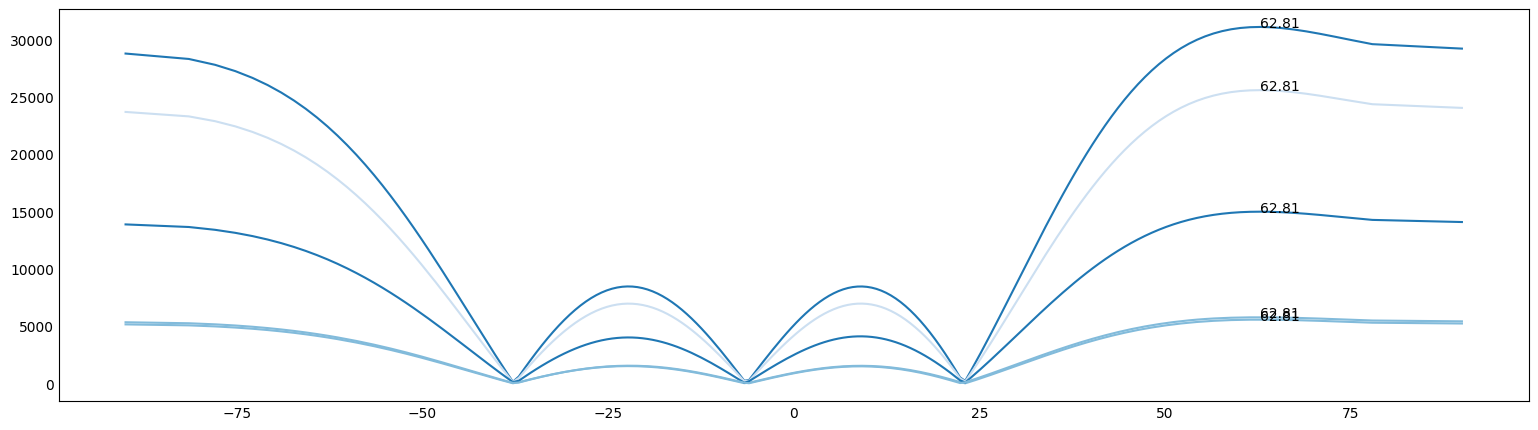

In [69]:
THRESHLOD = 10000

## initialize
fft_angle = np.zeros((n_antenna), dtype = 'complex_')  # complex를 살려줘야 한다. 실수로만 하니 당연히 대칭!!
fft_angle2 = np.zeros((angle_size), dtype = 'complex_')  # complex를 살려줘야 한다. 실수로만 하니 당연히 대칭!!
Cov_Mat = np.zeros((n_antenna, n_antenna)).astype('complex_') # complex가 중요하다.

range_FFT = np.fft.fft(Rx_sig[:,:,:])   # 내가 안테나 하나로 고정했잖아!!
range_idx, doppler_idx = np.where(dB_Doppler_fft == 1)
find_num = len(range_idx)
print(find_num)

plt.figure(figsize=(15, 4))
## angle FFT
# for chirp_idx in range(doppler_fft_size):
for idx in range(find_num):
    fft_angle = np.fft.fftshift(np.fft.fft(range_FFT[:, doppler_idx[idx], range_idx[idx]], angle_size))
    abs_res = abs(fft_angle)
    plt.plot(pt_angle, abs_res)
    for i in range(angle_size):
        if abs_res[i] >= max(abs_res):
            plt.text(pt_angle[i], abs_res[i], '{:.2f}'.format(pt_angle[i]))

#### Angle FFT Algorithm

real range: [22.360679774997898, 11.180339887498949]
real angle: [63.43494882 63.43494882]


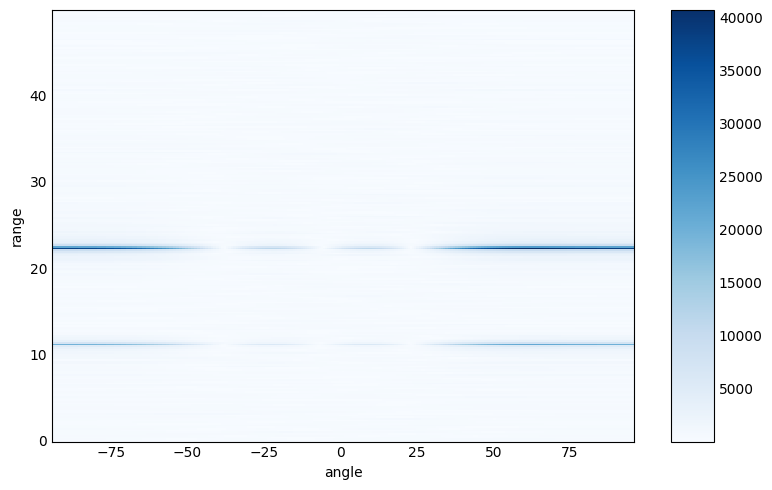

In [70]:
range_FFT = np.fft.fft(Rx_sig[:,:,:])   # 내가 안테나 하나로 고정했잖아!!
angle_FFT = np.fft.fftshift(np.fft.fft(range_FFT[:, :, :], angle_size, 0), 0)   # angle에 대해서 fftshift를 해줘야 한다.
range_az = np.abs(np.transpose(np.squeeze(np.sum(angle_FFT, axis=1))))

print(f'real range: {pt_ranges}')
print(f'real angle: {(np.array(pt_angles) * 180 / np.pi).flatten()}')

plt.figure(figsize=(8, 5))
pmesh = plt.pcolormesh(pt_angle.flatten(), pt_range.flatten(), range_az)
plt.xlabel('angle'); plt.ylabel('range')

plt.colorbar(pmesh, aspect=10)
plt.tight_layout()

#### MUSIC Algorithm

##### Functions & indexes

In [71]:
# Functions
def music(CovMat, n_pt, n_antenna):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    # array holds the positions of antenna elements
    # Angles are the grid of directions in the azimuth angular domain
    global angle_size, s_vec_rx_angle
    
    _, V = LA.eig(CovMat)
    Qn  = V[:, n_pt:n_antenna]

    pspectrum = np.zeros(angle_size)
    pspectrum = 1/LA.norm((Qn.conj().transpose() @ s_vec_rx_angle), axis=0)
    
    psindB       = np.log10(10*pspectrum/pspectrum.min())
    DoAsMUSIC, _ = ss.find_peaks(psindB,height=1.35, distance=1.5)
    return DoAsMUSIC, pspectrum

def esprit(CovMat,L,N):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    _,U = LA.eig(CovMat)
    S = U[:,0:L]
    Phi = LA.pinv(S[0:N-1]) @ S[1:N] # the original array is divided into two subarrays [0,1,...,N-2] and [1,2,...,N-1]
    eigs,_ = LA.eig(Phi)
    DoAsESPRIT = np.arcsin(np.angle(eigs)/np.pi)
    return DoAsESPRIT
#=============================================================



## index 찾기
THRESHLOD = 3   # 하나의 물체로 인지하고자 하는 속도의 차이의 최대값
cnt = np.zeros((len(range_idx)), dtype='int64')

for index in range(len(range_idx)):
    a = np.where(range_idx == range_idx[index])[0]
    if len(a) >= 2:
        for idx in (a-1):
            if np.abs(doppler_idx[idx] - doppler_idx[idx+1]) > THRESHLOD:
                cnt[index] += 1

    
cnt[cnt == 0] = 1   # coherence가 없더라도 1을 더해줘야 한다.

##### MUSIC Algorithm

0 check [[1.09955743]]
2 check [[1.09955743]]
real coordinate: [[1, (20, 10)], [2, (10, 5)]]
estimation coordinate: [[1, (20, 10)], [2, (10, 5)]]
ranges: [22.360679774997898, 11.180339887498949]


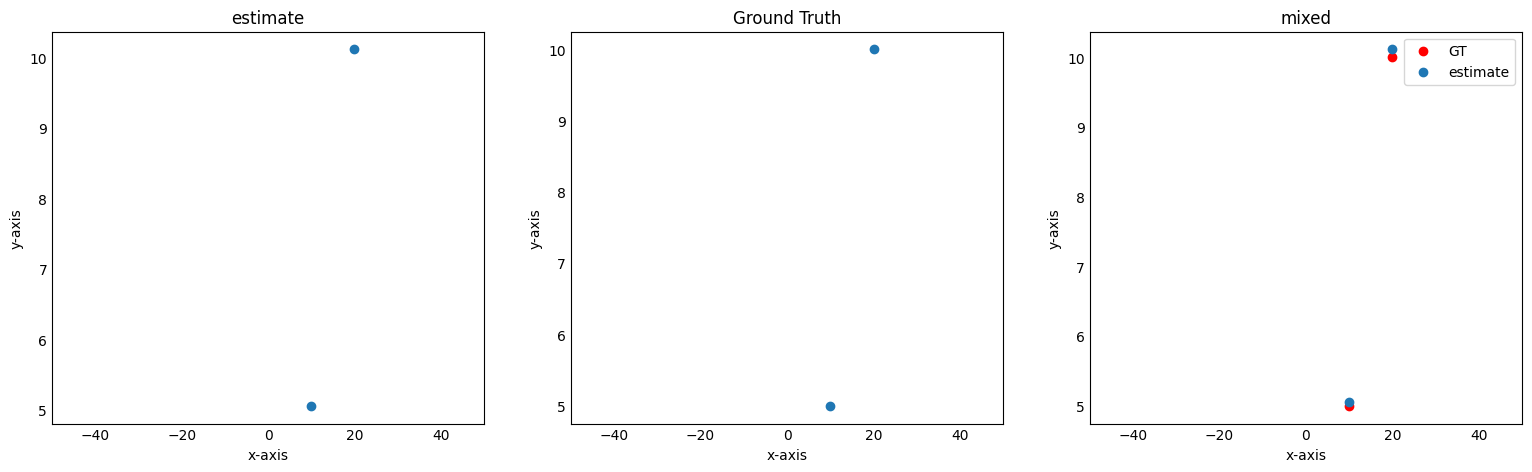

In [106]:
plt.figure(figsize=(15, 4))

## Music
THRESHLOD_COHERENCE_RANGE, MAX_SNAPSHOT = 1, 20       # range_Resolution을 결정한다. --> 이를 줄이면, resolution 증가하지만 동일거리에서 힘들다. (각도에도 영향)
MAX_ESCAPE_CNT = 2                                    # 비슷한 거리의 물체가 많아서 연속적인 물체의 차이가 클 때 이를 보완하고자 하는 것
angle_estimate, CovMat = {}, np.zeros((n_antenna, n_antenna, MAX_SNAPSHOT)).astype('complex_') # complex가 중요하다.
escape_cnt = 0

for idx in range(len(cnt)):
    if np.abs(range_idx[idx] - range_idx[idx - 1]) > THRESHLOD_COHERENCE_RANGE or escape_cnt > MAX_ESCAPE_CNT or idx == 0 : # coherence range & first index is always pass
        escape_cnt = 0
        CovMat = np.zeros((n_antenna, n_antenna, MAX_SNAPSHOT)).astype('complex_') # complex가 중요하다.

        for _ in range(MAX_SNAPSHOT):
            CovMat[:,:,_] = range_FFT[:,_,range_idx[idx]:range_idx[idx]+1] @ range_FFT[:,_,range_idx[idx]:range_idx[idx]+1].conj().transpose()

        CovMat = CovMat.mean(axis=2)
        DoAsMUSIC, psindB = music(CovMat, cnt[idx], n_antenna)  # MUSIC algorithm

        angle_estimate[float(pt_range[range_idx[idx]])] = angles_range[DoAsMUSIC].flatten() # * 180 / np.pi
        print(f'{idx} check {angles_range[DoAsMUSIC]}')   # 같은 거리에서 누구를 찾는 지를 확인할 수 있다.
    
    else:
        escape_cnt += 1

# 좌표 구하기
func = lambda my_dict: ([my_dict[0] * np.sin(my_dict[1])], [my_dict[0] * np.cos(my_dict[1])])
coord_estimate = np.concatenate(list(map(func, angle_estimate.items())), axis = 2).reshape(2, -1)
coord_GT = np.transpose(np.concatenate(list(map(lambda loc: loc['location'], pt)))[:, :2])    # x, y축만!

plt.subplot(131)
plt.scatter(*coord_estimate)
plt.xlim([-range_max, range_max])
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title("estimate")

plt.subplot(132)
plt.scatter(*coord_GT)
plt.xlim([-range_max, range_max])
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title("Ground Truth")

plt.subplot(133)
plt.scatter(*coord_GT, label="GT", color="red")
plt.scatter(*coord_estimate, label="estimate")
plt.xlim([-range_max, range_max])
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title("mixed")
plt.legend()

print(f'real coordinate: {[[idx, (x, y)] for idx, (x, y) in enumerate(coord_GT, 1)]}')
print(f'estimation coordinate: {[[idx, (round(x, 2), round(y, 2))] for idx, (x, y) in enumerate(coord_GT, 1)]}')
print(f'ranges: {pt_ranges}')